In [2]:
import numpy as np

import keras
import keras.backend as K
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.fugure_format = 'retina'

%load_ext autoreload

/home/semyon/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
print(K.image_data_format())

channels_last


In [4]:
IMAGE_PATCH_SHAPE = (64, 64, 1)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, Flatten, BatchNormalization, Activation
from keras.regularizers import l2
    
WEIGHT_DECAY = 5e-4 / 2 # for weight regularization
    
# siam-l2 from "Learning to Compare Image Patches via Convolutional Neural Networks"
descriptor = Sequential()

descriptor.add(Lambda(lambda x : x / 255, input_shape=IMAGE_PATCH_SHAPE))

descriptor.add(Conv2D(96, kernel_size=7, strides=3))#, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
#descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(192, kernel_size=5, strides=1))#, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
#descriptor.add(Dropout(0.2))

descriptor.add(Conv2D(256, kernel_size=3, strides=1))#, kernel_regularizer=l2(WEIGHT_DECAY)))
descriptor.add(BatchNormalization())
descriptor.add(Activation('relu'))
descriptor.add(Flatten())

descriptor.add(Lambda(lambda x : tf.nn.l2_normalize(x, axis=1))) # TODO check normalization

print(descriptor.input_shape, descriptor.output_shape)

(None, 64, 64, 1) (None, 256)


In [15]:
from keras.models import Model
from keras.layers import Input

input_a = Input(shape=IMAGE_PATCH_SHAPE)
input_b = Input(shape=IMAGE_PATCH_SHAPE)

descriptor_a = descriptor(input_a)
descriptor_b = descriptor(input_b)

def euclidean_distance(vects):
    assert len(vects) == 2
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon())) / 2

distance = Lambda(euclidean_distance)([descriptor_a, descriptor_b])
model = Model(inputs=[input_a, input_b], outputs=distance)

print(model.input_shape, model.output_shape)

[(None, 64, 64, 1), (None, 64, 64, 1)] (None, 1)


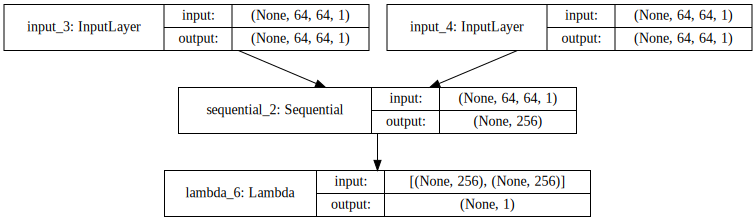

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
DATA_ROOT = '../data'
NOTREDAME = f'{DATA_ROOT}/notredame'
LIBERTY = f'{DATA_ROOT}/liberty'

!ls {NOTREDAME}/m50_*.txt

../data/notredame/m50_100000_100000_0.txt
../data/notredame/m50_10000_10000_0.txt
../data/notredame/m50_1000_1000_0.txt
../data/notredame/m50_200000_200000_0.txt
../data/notredame/m50_20000_20000_0.txt
../data/notredame/m50_2000_2000_0.txt
../data/notredame/m50_500000_500000_0.txt
../data/notredame/m50_50000_50000_0.txt
../data/notredame/m50_5000_5000_0.txt


In [18]:
%autoreload
from keras.losses import hinge
from keras.optimizers import Adam 
from utils import contrastive_loss

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=Adam(), metrics=[accuracy])

In [19]:
!rm -r siam-l2-logs

In [11]:
#model.load_weights('siam-l2-weights.hdf5')

In [20]:
from utils import create_generator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from batchtensorboard import BatchTensorBoard

NUM_TRAIN_PAIRS = 500000
NUM_VAL_PAIRS = 100000
BATCH_SIZE = 128
NUM_TRAIN_STEPS = NUM_TRAIN_PAIRS // BATCH_SIZE
NUM_VAL_STEPS = NUM_VAL_PAIRS // BATCH_SIZE

train_generator = create_generator(NOTREDAME, NUM_TRAIN_PAIRS, BATCH_SIZE, augmentate=False)
validation_generator = create_generator(LIBERTY, NUM_VAL_PAIRS, BATCH_SIZE, augmentate=False)

tensorboard = BatchTensorBoard(log_dir='siam-l2-logs')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001)
checkpointer = ModelCheckpoint('siam-l2-weights.hdf5')

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_STEPS, epochs=100, 
    validation_data=validation_generator, validation_steps=NUM_VAL_STEPS, 
    callbacks=[tensorboard, checkpointer])

Epoch 1/100
 594/3906 [===>..........................] - ETA: 1:23 - loss: 0.1319 - accuracy: 0.8902

In [20]:
inputs, true = next(create_generator(LIBERTY, num_pairs=1000, batch_size=1000, augmentate=False))
pred = model.predict(inputs, verbose=1)

5000/5000 [==============================] - 1s 108us/step


In [18]:
print(pred.reshape(-1)[:30])

[0.30038694 0.5317392  0.29034096 0.7059352  0.4627948  0.7064267
 0.40201914 0.6590836  0.09882125 0.7018737  0.31083435 0.6621353
 0.2420168  0.56625205 0.3038276  0.697805   0.24359345 0.59532356
 0.45505473 0.6579657  0.26673296 0.5912671  0.3845817  0.6703302
 0.07579787 0.7013925  0.3430462  0.7005761  0.21008731 0.3759659 ]


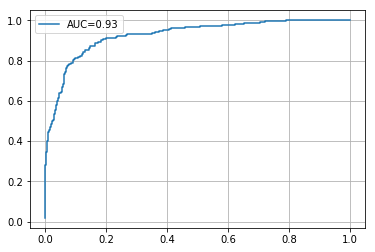

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true, pred)
roc_auc = auc(fpr, tpr)
plt.grid()
plt.plot(fpr, tpr, label=f'AUC={roc_auc:0.2f}')
plt.legend()
plt.show()

In [16]:
model.layers

In [17]:
descr = model.layers[2]
embeddings = descr.predict(inputs[1])

In [18]:
from numpy.linalg import norm

sum(norm(e) for e in embeddings)

4998.999891936779

In [19]:
x = 228

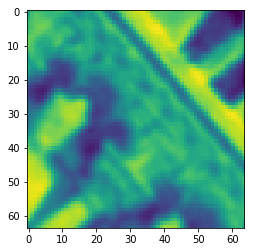

In [20]:
plt.imshow(inputs[1][x].reshape(64, 64));

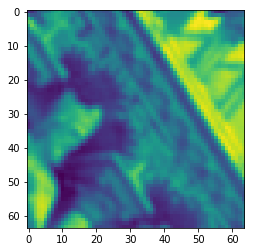

In [21]:
plt.imshow(inputs[0][x].reshape(64, 64));

In [22]:
pred[x]

array([0.29639417], dtype=float32)

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(pred > 0.5, true)

0.967